## Imports

In [2]:
import sys 
import os
import numpy as np 
import matplotlib.pyplot as plt
from skimage import io
import math
import copy

import torch
import torchvision 
import torch.optim as optim
import torch.nn as nn
from torch.utils.data.dataset import Dataset
sys.path.insert(0, '../../Utils')

import models
from train import *
from metrics import * 
#from Gradient_Ascent import data_extraction
from skimage.restoration import denoise_nl_means, estimate_sigma

from PIL import Image
import pdb

print("Python: %s" % sys.version)
print("Pytorch: %s" % torch.__version__)

Python: 3.7.2 (default, Feb 21 2019, 17:35:59) [MSC v.1915 64 bit (AMD64)]
Pytorch: 1.4.0+cu92


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Hyperparameters

In [4]:
n_epochs = 40
batch_size = 32
lr = 0.01
train_percent = 0.7

## Load ATT Dataset

In [5]:
class ATTdataset(Dataset): 
    def __init__(self, file_list, class_to_label, transform=None): 
        self.file_list = file_list
        self.transform = transform        
        self.people_to_idx = class_to_label
        
                
    def __len__(self): 
        return len(self.file_list)
    
    def __getitem__(self, idx): 
        image = np.empty((112, 92, 1), dtype=np.uint8)
        img_path = self.file_list[idx]
        im = io.imread(img_path)
        im = im.reshape(112,92)
        image[:,:,0]= im
        label = self.people_to_idx[img_path.split('\\')[-2]]
        if self.transform is not None: 
            image = self.transform(image)
        return image, label        

In [6]:
data_dir = "..\\..\\attfaces"

img_paths = []
for p in os.listdir(data_dir): 
    for i in os.listdir(os.path.join(data_dir,p)): 
        img_paths.append(os.path.join(data_dir,p,i))
        
people = []
people_to_idx = {}
idx_to_people = {}
sample_paths = []
k = 0 
for i in img_paths: 
    name = i.split('\\')[-2]
    if name not in people_to_idx: 
        people.append(name)
        people_to_idx[name] = k
        idx_to_people[k] = name
        k += 1
        sample_paths.append(i)

img_paths = np.random.permutation(img_paths)

lfw_size = len(img_paths)
lfw_train_size = int(train_percent * lfw_size)
lfw_train_list = img_paths[:lfw_train_size]
lfw_test_list = img_paths[lfw_train_size:]

# Data augmentation 
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

test_transform = torchvision.transforms.Compose([    
    torchvision.transforms.ToTensor(),
])

trainset = ATTdataset(lfw_train_list, people_to_idx, transform=train_transform)
testset = ATTdataset(lfw_test_list, people_to_idx, transform=test_transform)
sampleset = ATTdataset(sample_paths, people_to_idx, transform=torchvision.transforms.ToTensor())

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=0)
sampleloader = torch.utils.data.DataLoader(sampleset, batch_size=40, shuffle=False, num_workers=0)

<class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> torch.Size([3, 572, 754])
<class 'numpy.ndarray'> (3, 572, 754)
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39])
tensor(0.)
tensor(0.9569)
torch.Size([40, 1, 112, 92])


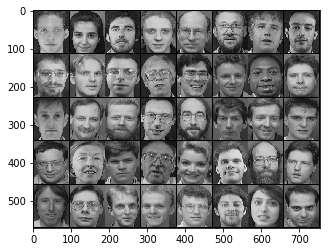

In [7]:
# helper function to unnormalize and plot image 
def imshow(img, name):
    print(type(img), img.shape)
    img = np.array(img)
    #img = img / 2 + 0.5
    print(type(img), img.shape)
    img = np.moveaxis(img, 0, -1)
    plt.imshow(img)
    plt.imsave('.\\'+name, img)
    
# display sample from dataset 
imgs,labels = iter(sampleloader).next()
print(type(imgs), type(torchvision.utils.make_grid(imgs)))
imshow(torchvision.utils.make_grid(imgs),'origin') 
print(labels)
print(imgs.min())
print(imgs.max())
print(imgs.shape)

## Model Architecture

In [8]:
class mlp(nn.Module): 
    def __init__(self, n_in=112*92, n_out=40, n_hidden=3000): 
        super(mlp, self).__init__()
        self.hidden1 = nn.Linear(n_in, n_out)        

    def forward(self, x):
        x = x.view(-1,112*92)
        out = self.hidden1(x)
        return out

## Training 

In [486]:
ww0_shape = nn.Linear(112*92, 40).weight.data.shape
print(ww0_shape)

torch.Size([40, 10304])


In [487]:
net2 = mlp().to(device)
net2.apply(models.weights_init)
criterion = nn.CrossEntropyLoss()
optimizer2 = optim.SGD(net2.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
ww0 = copy.deepcopy(net2.hidden1.weight.data)
bb0 = copy.deepcopy(net2.hidden1.bias.data)
train_accs, test_accs = train(net2, trainloader, testloader, optimizer2, criterion, n_epochs, verbose=False)

[0/40]
Train Accuracy = 7.86 %; Test Accuracy = 5.83 %
[1/40]
Train Accuracy = 25.00 %; Test Accuracy = 20.83 %
[2/40]
Train Accuracy = 47.86 %; Test Accuracy = 35.83 %
[3/40]
Train Accuracy = 76.07 %; Test Accuracy = 54.17 %
[4/40]
Train Accuracy = 79.29 %; Test Accuracy = 55.00 %
[5/40]
Train Accuracy = 85.71 %; Test Accuracy = 60.83 %
[6/40]
Train Accuracy = 89.64 %; Test Accuracy = 82.50 %
[7/40]
Train Accuracy = 96.07 %; Test Accuracy = 69.17 %
[8/40]
Train Accuracy = 91.79 %; Test Accuracy = 81.67 %
[9/40]
Train Accuracy = 98.93 %; Test Accuracy = 78.33 %
[10/40]
Train Accuracy = 98.21 %; Test Accuracy = 86.67 %
[11/40]
Train Accuracy = 99.64 %; Test Accuracy = 92.50 %
[12/40]
Train Accuracy = 100.00 %; Test Accuracy = 93.33 %
[13/40]
Train Accuracy = 100.00 %; Test Accuracy = 92.50 %
[14/40]
Train Accuracy = 100.00 %; Test Accuracy = 92.50 %
[15/40]
Train Accuracy = 100.00 %; Test Accuracy = 95.00 %
[16/40]
Train Accuracy = 100.00 %; Test Accuracy = 92.50 %
[17/40]
Train Accurac

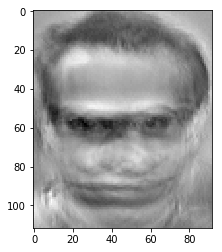

In [458]:
ww = copy.deepcopy(net2.hidden1.weight.data)
bb = copy.deepcopy(net2.hidden1.bias.data[:])
i = 39
im0 = ww0[i,:].reshape(1,1,112,92)
im_train = ww[i,:].reshape(1,1,112,92)
plt.imshow((im_train-im0).squeeze().cpu().detach().numpy(),cmap='gray')
plt.show()

real_imgs_size = torch.Size([40,1,112,92])
real_imgs = torch.zeros(real_imgs_size)
for i in range(40):
    im0 = ww0[i,:].reshape(1,1,112,92)
    im_train = ww[i,:].reshape(1,1,112,92)
    real_imgs[i] = im_train-im0

## DRAM Bit Error Introduction

### Float Binary Conversion and Evaluation in CPU

In [149]:
# Determine the fixed point exponent
nbits = 32 # with one-bit sign
arr = copy.deepcopy(ww[39,:].reshape(1,1,112,92)).squeeze().cpu().detach().numpy().reshape(-1)
weight_max = np.absolute(arr).max()
fixed_exp = np.ceil(np.log2(weight_max/(2**(nbits-1)-1)))

In [46]:
def float2bin_cpu(num, fixed_exp):
    if num >= 0:
        s = '0'
        tmp = bin(int(num / (2**fixed_exp)))[2:]
    else:
        s = '1'
        tmp = bin(int(num / (2**fixed_exp)))[3:]
    s += '0'*(nbits-1-len(tmp)) + tmp
    return s

In [47]:
def bin2float_cpu(s, fixed_exp):
    if s[0] == '0':
        num = 1.0
    else:
        num = -1.0
    num *= int(s[1:],2) * 2**fixed_exp
    return num

In [56]:
# evaluation
for i in range(len(arr)):
    test = arr[i]
    rec = bin2float_cpu(float2bin_cpu(test, fixed_exp),fixed_exp)
    if np.absolute(test-rec) <= 2**fixed_exp:
        continue
    else:
        print(i, test, rec)

### Float Binary Conversion and Evaluation in GPU

In [441]:
def float2bin_gpu(f, fixed_exp, nbits=8):
    s = torch.sign(f)
    f = f * s
    s = (s * (-1) + 1.) * 0.5
    s= s.unsqueeze(-1)
    f = f/(2**fixed_exp)
    m = integer2bit(f - f % 1,num_bits = nbits-1)
    dtype = f.type()
    out = torch.cat([s, m], dim=-1).type(dtype)
    return out

In [440]:
def integer2bit(integer, num_bits=7):
    dtype = integer.type()
    exponent_bits = -torch.arange(-(num_bits - 1), 1).type(dtype)
    exponent_bits = exponent_bits.repeat(integer.shape + (1,))
    out = integer.unsqueeze(-1) / 2 ** exponent_bits
    return (out - (out % 1)) % 2

In [439]:
def bin2float_gpu(b, fixed_exp, nbits=8):
    dtype = torch.float32
    s = torch.index_select(b, -1, torch.arange(0, 1).to(device))
    m = torch.index_select(b, -1, torch.arange(1,nbits).to(device))
    out = ((-1) ** s).squeeze(-1).type(dtype)
    exponents = -torch.arange(-(nbits - 2.), 1.).to(device)
    exponents = exponents.repeat(b.shape[:-1] + (1,))
    e_decimal = torch.sum(m * 2 ** (exponents), dim=-1)
    out *= e_decimal * 2 ** fixed_exp
    return out

In [451]:
# evaluation
nbits = 8
for i in range(40):
    f = ww[i,:]
    weight_max = torch.max(f)
    fixed_exp = torch.ceil(torch.log2(weight_max/(2**(nbits-1)-1))) + 1
    rec = bin2float_gpu(float2bin_gpu(f, fixed_exp),fixed_exp)
    if not torch.all((rec - f) <= 1 * 2**fixed_exp):
        print(i, '1 binary float conversion failed')
    if not torch.all(rec - f >= -1 * 2**fixed_exp):
        print(i, '2 binary float conversion failed')

In [214]:
def bin_add_bit_error(b, bit_error_percent = 0):
    cond = torch.rand(b.shape).to(device) > bit_error_percent
    a = 1 - b
    out = cond * b + torch.logical_not(cond) * a
    return out

In [575]:
bit_error_percent = 0.1

accuracy_list = []
testacc_list = []
similarity_list = []

for i in range(100):
    cur_imgs = torch.zeros(real_imgs.shape)
    similarity = 0
    for k in range(40):
        im0 = ww0[k,:].reshape(1,1,112,92)
        f = ww[k,:]
        f_modify = bin2float_gpu(bin_add_bit_error(float2bin_gpu(f, fixed_exp), bit_error_percent), fixed_exp)
        cur_imgs[k] = f_modify.reshape(1,1,112,92)

        data = cur_imgs[k]/100.0
        data1 = real_imgs[k]/100.0
        # ncc = torch.sum(data*data1)/torch.sqrt(torch.sum(data**2))/torch.sqrt(torch.sum(data1**2))
        # similarity += -0.5*(ncc-1)
        # Pearson Correlation Coefficient
        vdata = data - torch.mean(data)
        vdata1 = data1 - torch.mean(data1)
        pcc = torch.sum(vdata*vdata1)/torch.sqrt(torch.sum(vdata**2))/torch.sqrt(torch.sum(vdata1**2))
        similarity += pcc

        net2.hidden1.weight.data[k,:] = f_modify

    accuracy_list.append( eval_target_net(net2, trainloader) )
    testacc_list.append( eval_target_net(net2, testloader) ) 
    similarity_list.append( similarity/40 )

Text(0.5, 1.0, 'pcc similarity between the images')

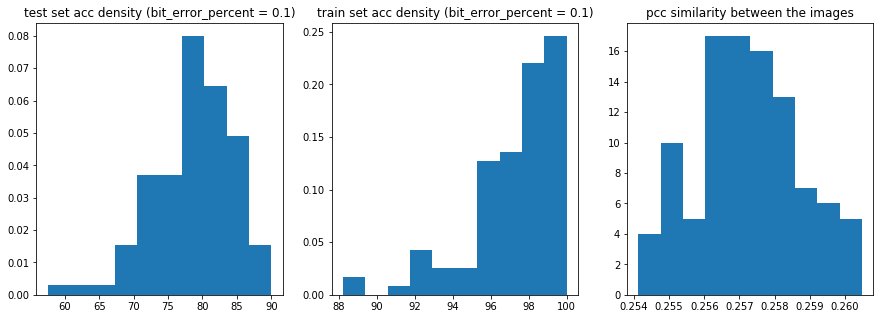

In [576]:
fig, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].hist(testacc_list, density=True)
ax[0].set_title('test set acc density (bit_error_percent = 0.1)')
ax[1].hist(accuracy_list, density=True)
ax[1].set_title('train set acc density (bit_error_percent = 0.1)')
ax[2].hist(similarity_list)
ax[2].set_title('pcc similarity between the images')

In [564]:
accuracy_list = []
testacc_list = []
similarity_list = []
ntests = 50
bit_error_percent_list = np.logspace(-6,-2,5,base=2)
for bit_error_percent in bit_error_percent_list:
    accuracy_avg, testacc_avg, similarity_avg = 0,0,0
    for i in range(ntests):
        cur_imgs = torch.zeros(real_imgs.shape)
        similarity = 0
        for k in range(40):
            im0 = ww0[k,:].reshape(1,1,112,92)
            f = ww[k,:]
            f_modify = bin2float_gpu(bin_add_bit_error(float2bin_gpu(f, fixed_exp), bit_error_percent), fixed_exp)
            cur_imgs[k] = f_modify.reshape(1,1,112,92)

            data = cur_imgs[k]/100.0
            data1 = real_imgs[k]/100.0
            # ncc = torch.sum(data*data1)/torch.sqrt(torch.sum(data**2))/torch.sqrt(torch.sum(data1**2))
            # similarity += -0.5*(ncc-1)
            # Pearson Correlation Coefficient
            vdata = data - torch.mean(data)
            vdata1 = data1 - torch.mean(data1)
            pcc = torch.sum(vdata*vdata1)/torch.sqrt(torch.sum(vdata**2))/torch.sqrt(torch.sum(vdata1**2))
            similarity += pcc

            net2.hidden1.weight.data[k,:] = f_modify

        accuracy_avg += eval_target_net(net2, trainloader) 
        testacc_avg  += eval_target_net(net2, testloader) 
        similarity_avg += similarity/40 
    accuracy_list.append(accuracy_avg / ntests)
    testacc_list.append(testacc_avg / ntests)
    similarity_list.append(similarity_avg / ntests)  

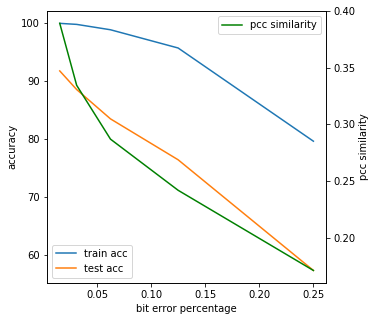

In [574]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax2 = ax.twinx()
ax.plot(bit_error_percent_list,accuracy_list)
ax.plot(bit_error_percent_list,testacc_list)
ax.set_xlabel('bit error percentage')
ax.set_ylabel('accuracy')
ax.legend(['train acc','test acc'],loc='lower left')
ax2.plot(bit_error_percent_list,similarity_list,'g-')
ax2.set_ylabel('pcc similarity')
ax2.legend(['pcc similarity'],loc='upper right')

In [543]:
np.logspace(-6,-2,5,base=2)

array([0.015625, 0.03125 , 0.0625  , 0.125   , 0.25    ])

In [455]:
f0 = ww0[39,:]
f = ww[39,:]
bit_error_percent = 0.1
f_modify = bin2float_gpu(bin_add_bit_error(float2bin_gpu(f, fixed_exp), bit_error_percent), fixed_exp)

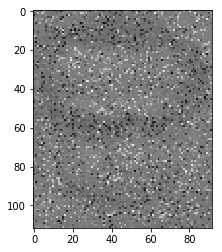

In [457]:
im0 = f0.reshape(1,1,112,92)
im = f_modify.reshape(1,1,112,92)
plt.imshow((im-im0).squeeze().cpu().detach().numpy(),cmap='gray')
plt.show()

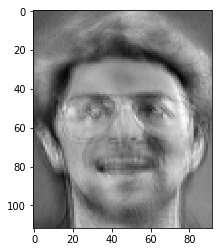

In [211]:
i = 37
im0 = ww0[i,:].reshape(1,1,112,92)
im_train = ww[i,:].reshape(1,1,112,92)
plt.imshow((im_train-im0).squeeze().cpu().detach().numpy(),cmap='gray')
plt.show()

In [ ]:
i = 37
im0 = ww0[i,:].reshape(1,1,112,92)
im_train = ww[i,:].reshape(1,1,112,92)
plt.imshow((im_train-im0).squeeze().cpu().detach().numpy(),cmap='gray')
plt.show()

(array([584., 614., 609., 540., 589., 600., 573., 490., 525., 466., 426.,
        456., 402., 385., 325., 302., 302., 237., 209., 181., 209., 157.,
        161., 154., 132., 100.,  90.,  77.,  70.,  55.,  58.,  42.,  26.,
         24.,  27.,  19.,  12.,  18.,  15.,   9.,   6.,   9.,   6.,   0.,
          3.,   1.,   2.,   1.,   4.,   2.]),
 array([3.32659306e-06, 1.29361451e-03, 2.58390233e-03, 3.87419038e-03,
        5.16447797e-03, 6.45476626e-03, 7.74505408e-03, 9.03534144e-03,
        1.03256302e-02, 1.16159180e-02, 1.29062058e-02, 1.41964937e-02,
        1.54867815e-02, 1.67770684e-02, 1.80673581e-02, 1.93576459e-02,
        2.06479337e-02, 2.19382215e-02, 2.32285094e-02, 2.45187972e-02,
        2.58090850e-02, 2.70993728e-02, 2.83896606e-02, 2.96799485e-02,
        3.09702363e-02, 3.22605222e-02, 3.35508138e-02, 3.48411016e-02,
        3.61313894e-02, 3.74216773e-02, 3.87119651e-02, 4.00022529e-02,
        4.12925407e-02, 4.25828286e-02, 4.38731164e-02, 4.51634042e-02,
        4.

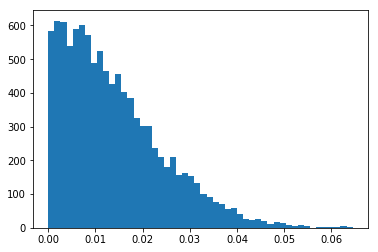

In [64]:
plt.hist(np.absolute(tmp.reshape(-1)),bins=50)